# medMorphoBin - First project computer vision

- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

repository link: https://github.com/bl33h/medMorphoBin

## Task 1

### implementing binarization algorithms

### Otzu

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readImage(path):
    return plt.imread(path)

In [3]:
def equalizeHist(image):
    hist, bins = np.histogram(image.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf = 255 * cdf / cdf[-1]
    equalized = np.interp(image.flatten(), bins[:-1], cdf)
    return equalized.reshape(image.shape).astype(np.uint8)

In [4]:
def applyOtsuThreshold(image):
    hist, binEdges = np.histogram(image.ravel(), bins=256, range=(0,256))
    hist = hist.astype(float)
    totalPixels = image.size

    currentMax, threshold = 0, 0
    sumTotal, sumB, wB, wF = np.dot(hist, np.arange(256)), 0, 0, 0

    for i in range(256):
        wB += hist[i]
        if wB == 0: continue
        wF = totalPixels - wB
        if wF == 0: break

        sumB += i * hist[i]
        meanB = sumB / wB
        meanF = (sumTotal - sumB) / wF

        varianceBetween = wB * wF * (meanB - meanF) ** 2

        if varianceBetween > currentMax:
            currentMax = varianceBetween
            threshold = i

    binaryImage = image > threshold
    return binaryImage.astype(np.uint8)

In [5]:
def evaluateMetrics(gt, pred):
    gtFlat, predFlat = gt.flatten(), pred.flatten()
    tp = np.sum((gtFlat == 1) & (predFlat == 1))
    tn = np.sum((gtFlat == 0) & (predFlat == 0))
    fp = np.sum((gtFlat == 0) & (predFlat == 1))
    fn = np.sum((gtFlat == 1) & (predFlat == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, specificity, f1

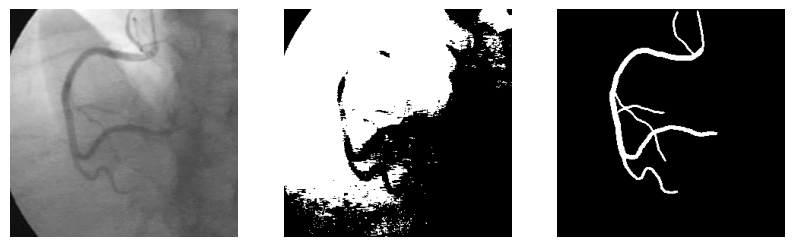

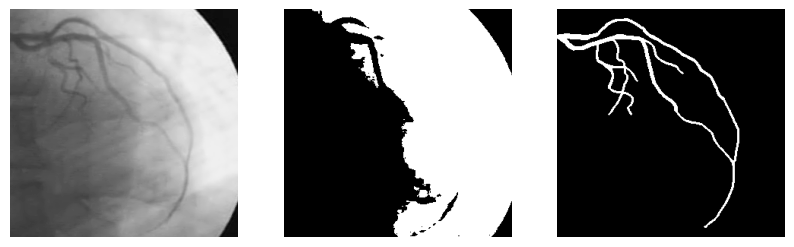

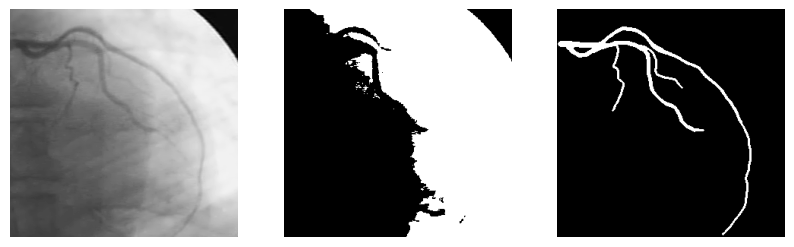

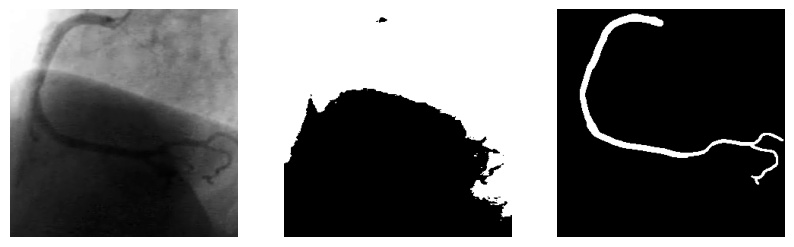

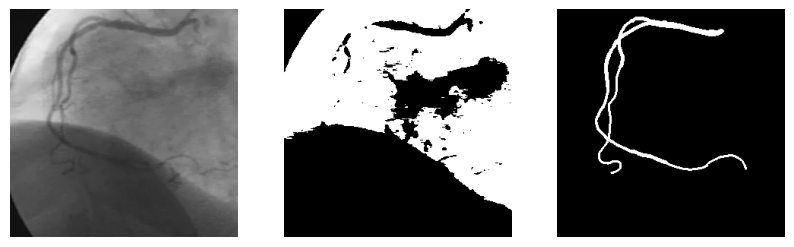

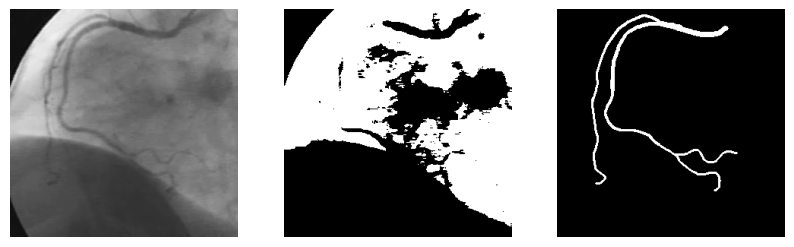

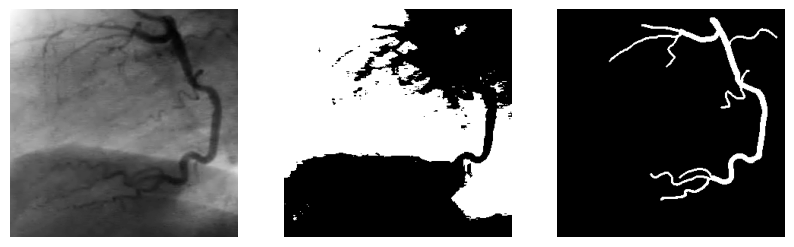

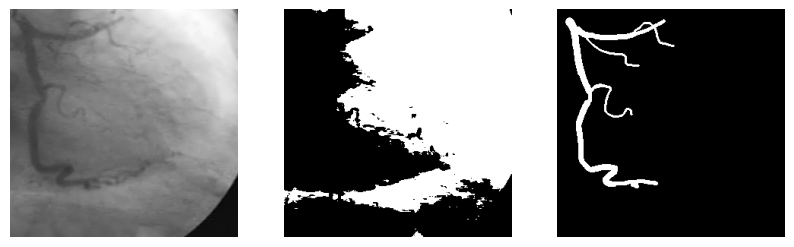

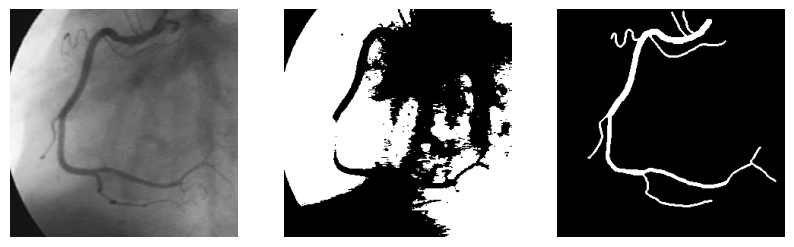

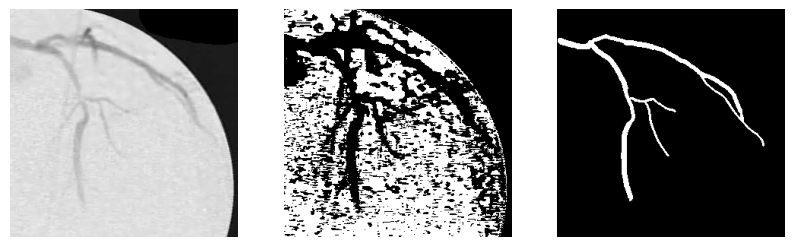

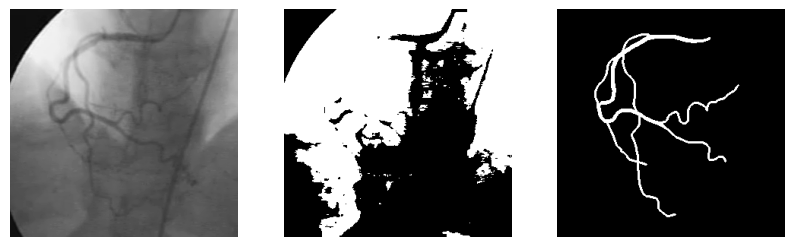

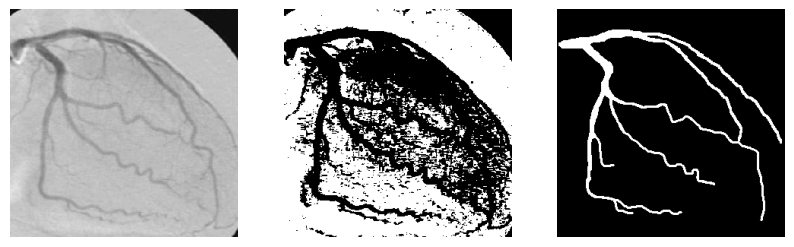

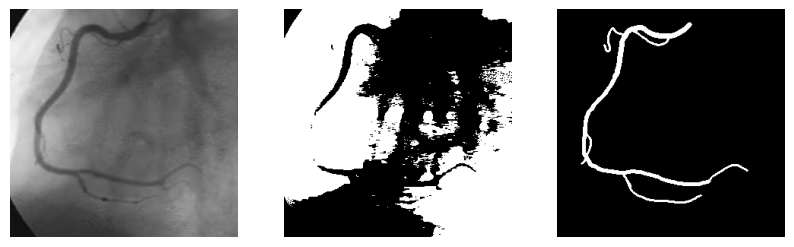

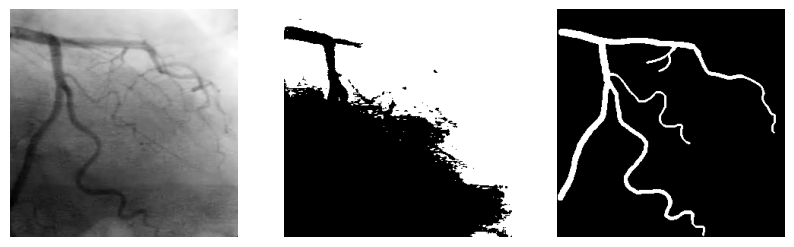

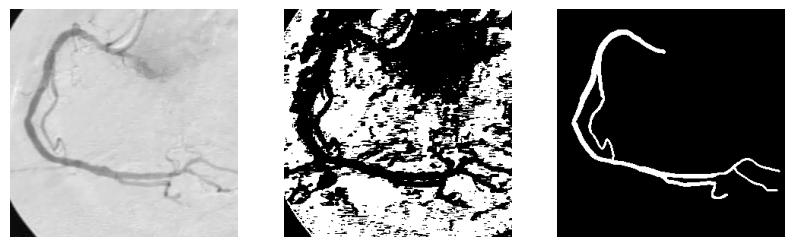

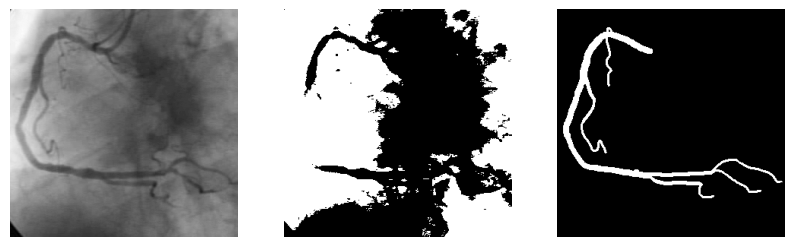

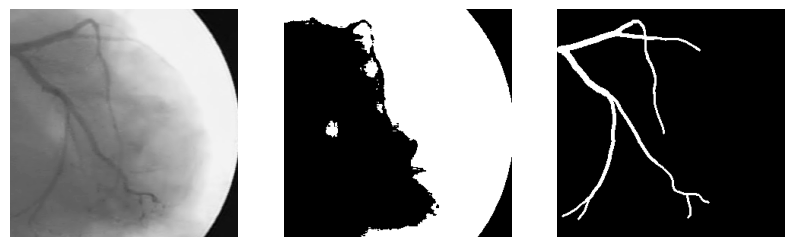

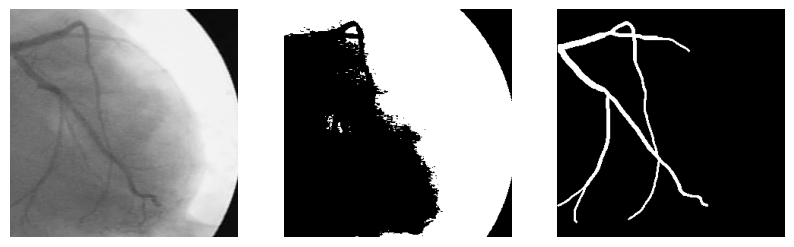

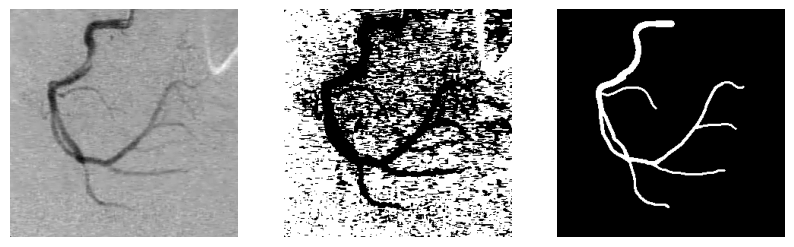

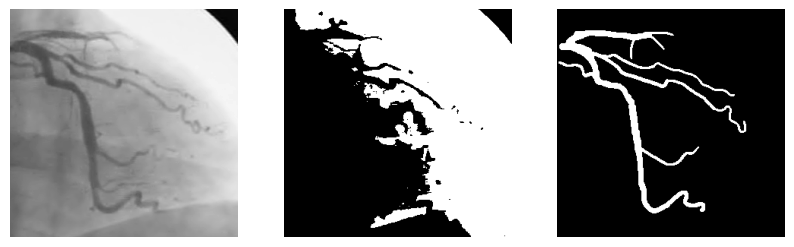

--- metrics otzu ---
accuracy: 0.4630533333333333
precision: 0.02001905341004555
recall: 0.219492295450606
specificity: 0.4764463101224825
f1 score: 0.0365645237759953


In [6]:
# main execution
path = "img/"
metricsSum = np.zeros(5)

for imgNum in range(1, 21):
    image = readImage(f"{path}{imgNum}.pgm")
    gtImage = readImage(f"{path}{imgNum}_gt.pgm")
    
    imageEq = equalizeHist(image)
    binaryImg = applyOtsuThreshold(imageEq)
    
    metrics = evaluateMetrics((gtImage==255).astype(np.uint8), binaryImg)
    metricsSum += metrics

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(binaryImg, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(gtImage, cmap='gray')
    plt.axis('off')

    plt.show()

metricsAvg = metricsSum / 20

print('--- metrics otzu ---')
print('accuracy:', metricsAvg[0])
print('precision:', metricsAvg[1])
print('recall:', metricsAvg[2])
print('specificity:', metricsAvg[3])
print('f1 score:', metricsAvg[4])

### Sauvola

In [7]:
def sauvolaThreshold(image, windowSize=23, k=0.4):
    rows, cols = image.shape
    padSize = windowSize // 2
    padded = np.pad(image, padSize, mode='reflect')
    thresholded = np.zeros_like(image)

    for i in range(rows):
        for j in range(cols):
            window = padded[i:i+windowSize, j:j+windowSize]
            meanLocal = np.mean(window)
            stdLocal = np.std(window)
            threshold = meanLocal * (1 + k * ((stdLocal / 128) - 1))
            thresholded[i, j] = threshold

    return thresholded

In [8]:
def evaluateMetrics(gt, pred):
    gtFlat, predFlat = gt.flatten(), pred.flatten()
    tp = np.sum((gtFlat == 1) & (predFlat == 1))
    tn = np.sum((gtFlat == 0) & (predFlat == 0))
    fp = np.sum((gtFlat == 0) & (predFlat == 1))
    fn = np.sum((gtFlat == 1) & (predFlat == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, specificity, f1

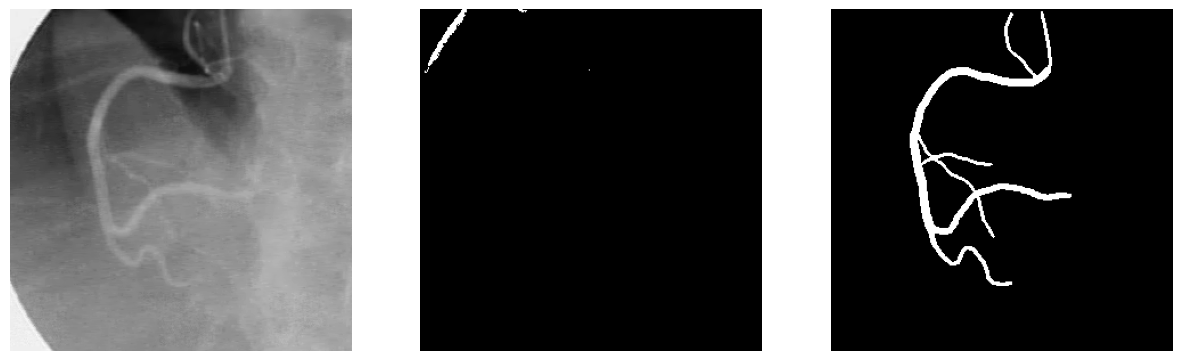

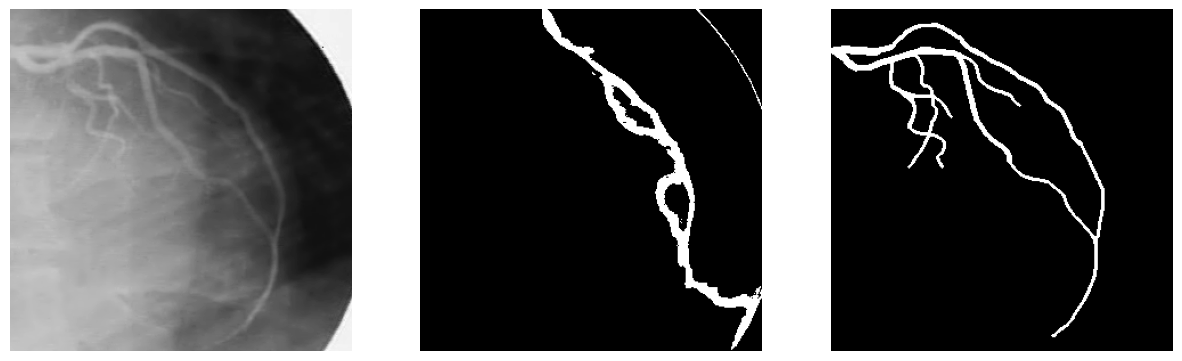

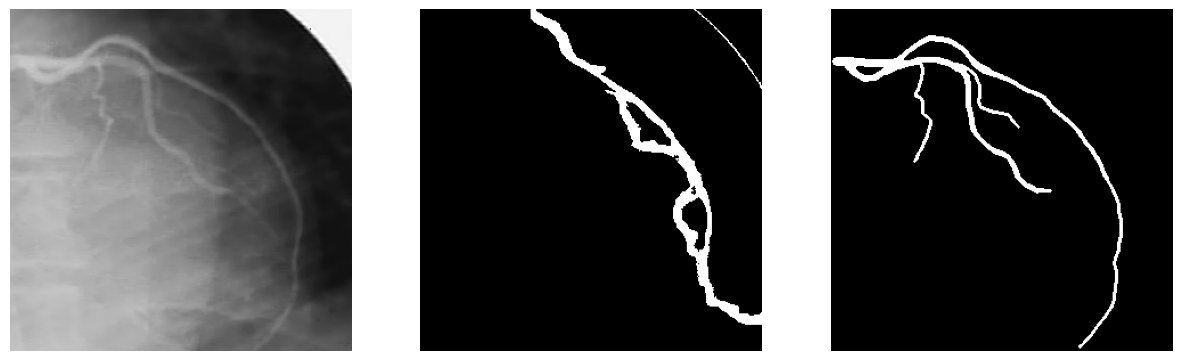

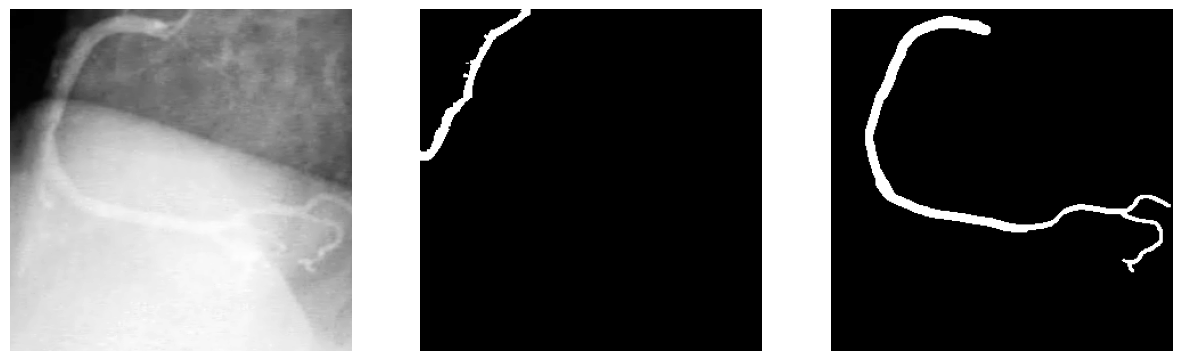

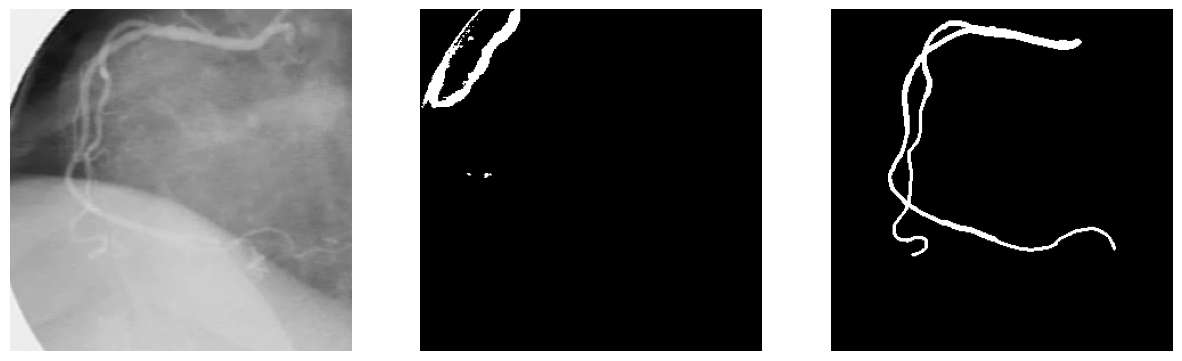

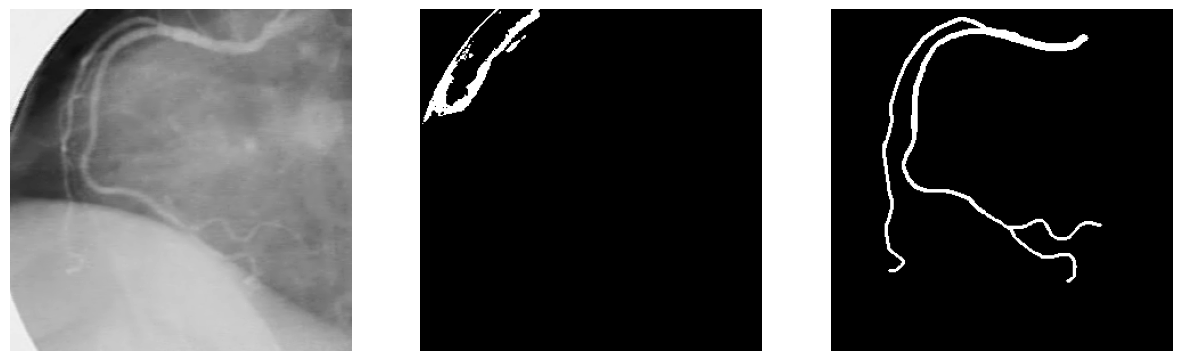

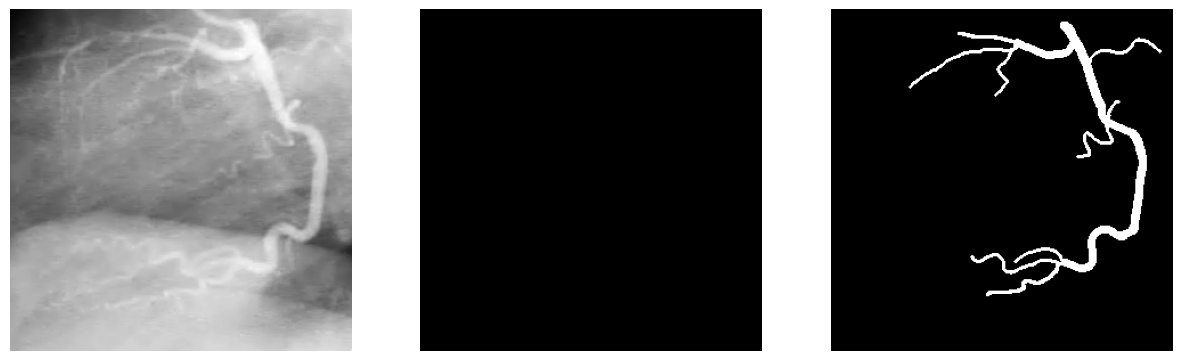

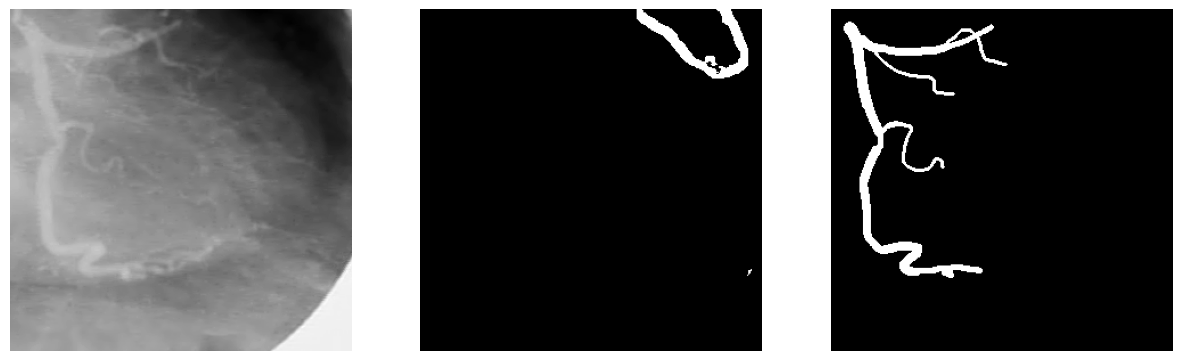

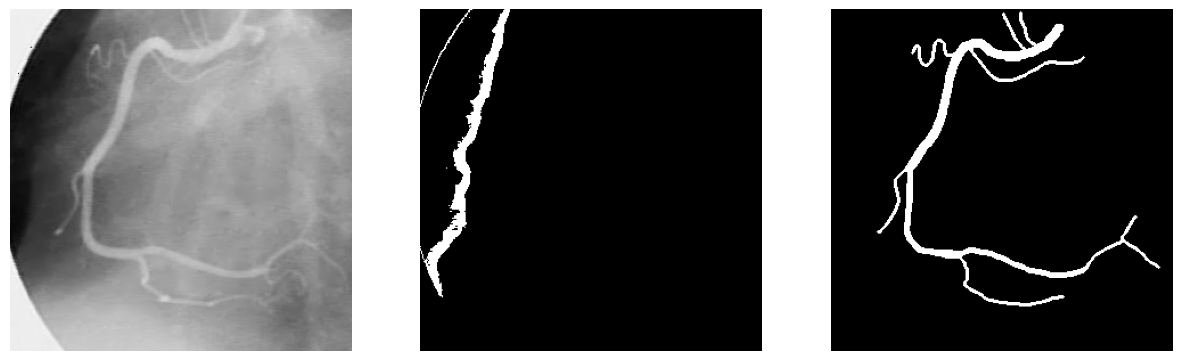

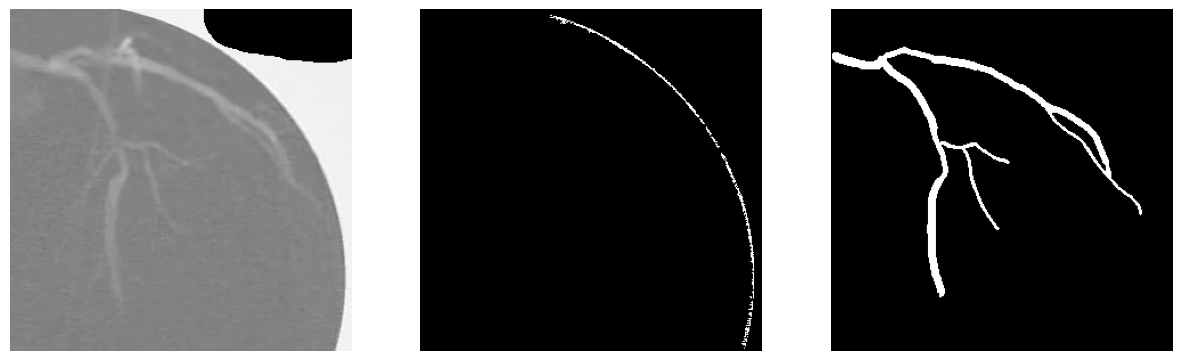

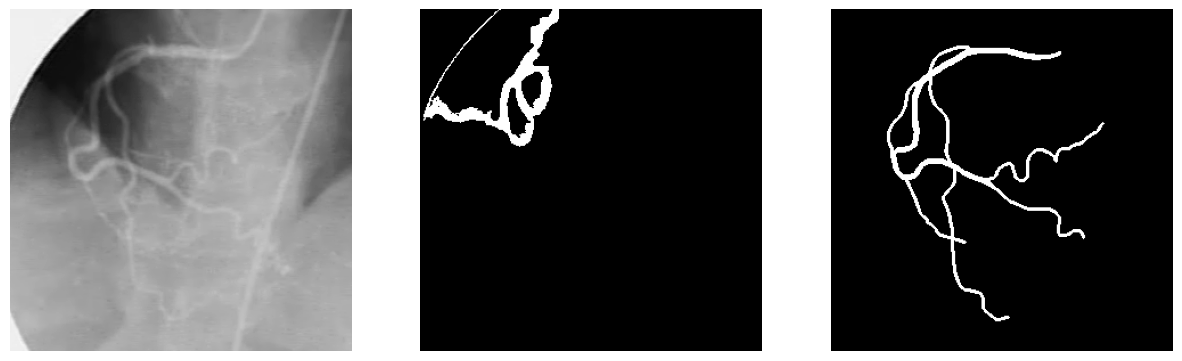

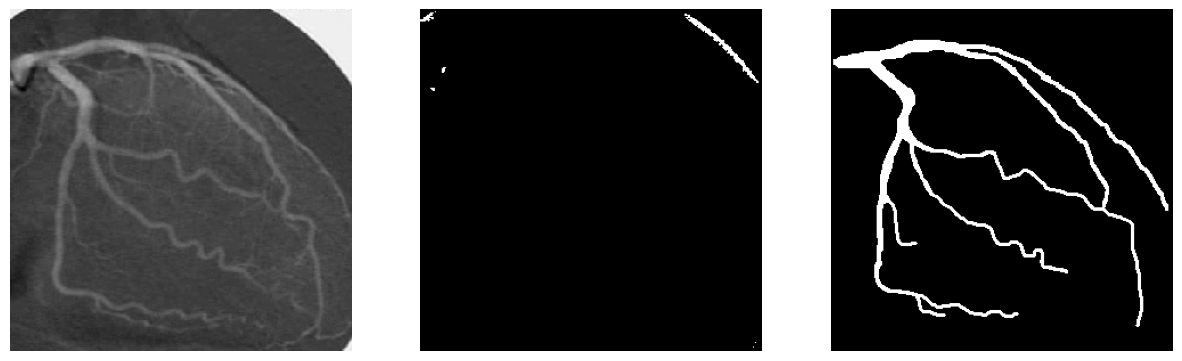

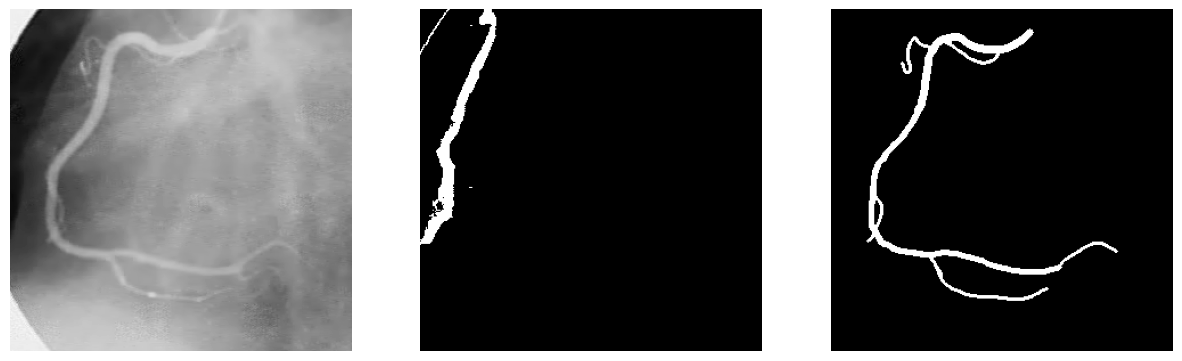

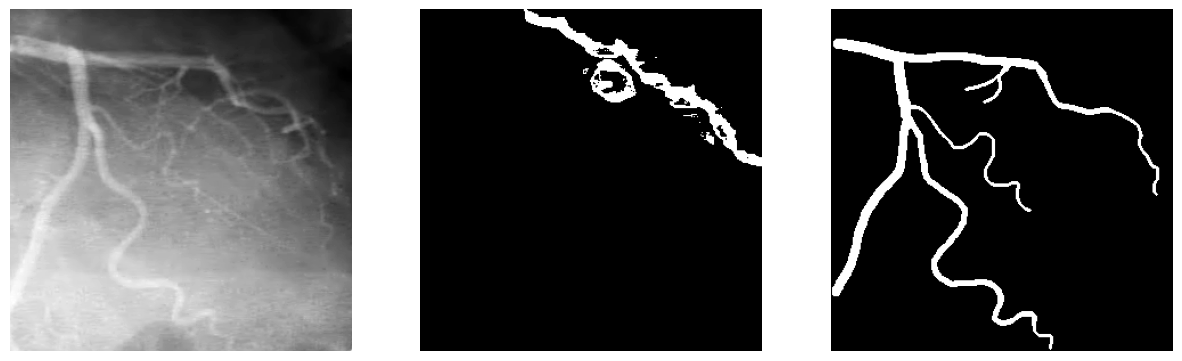

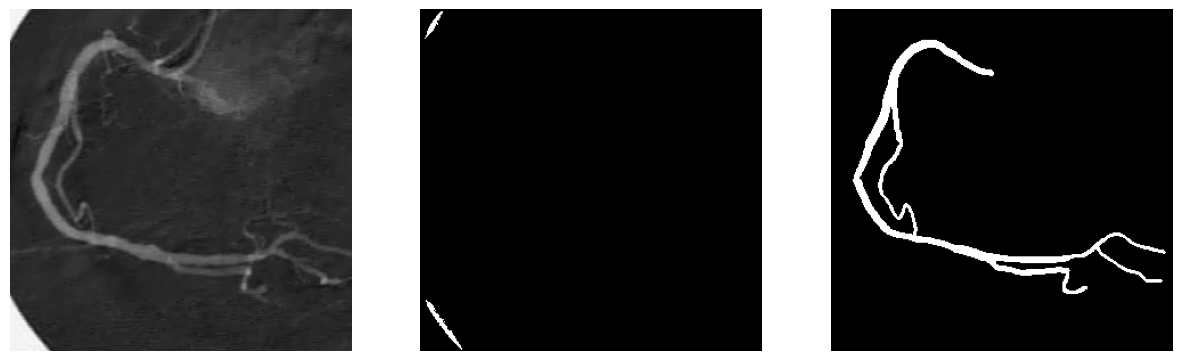

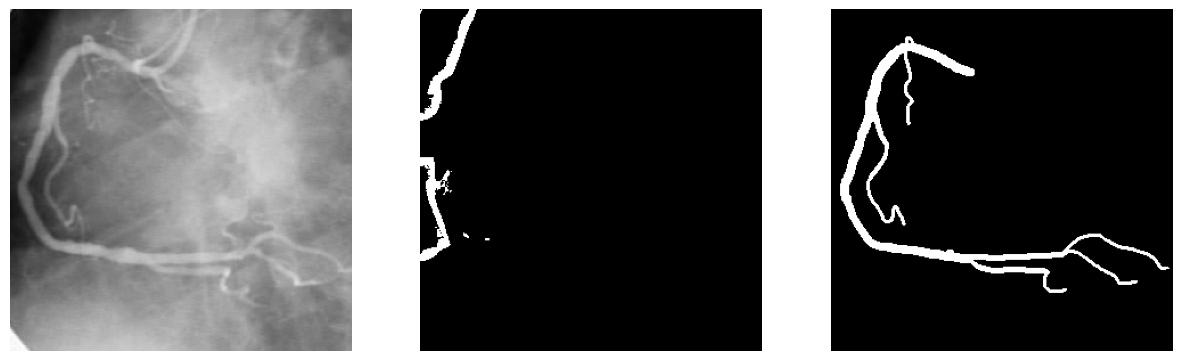

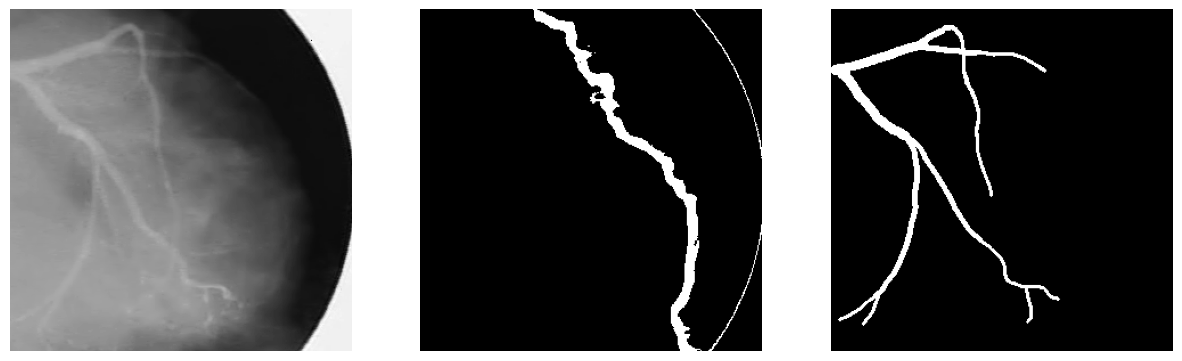

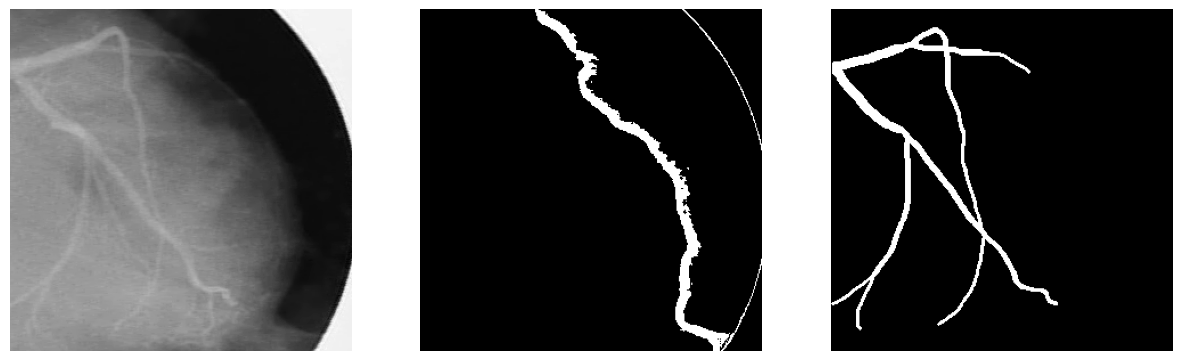

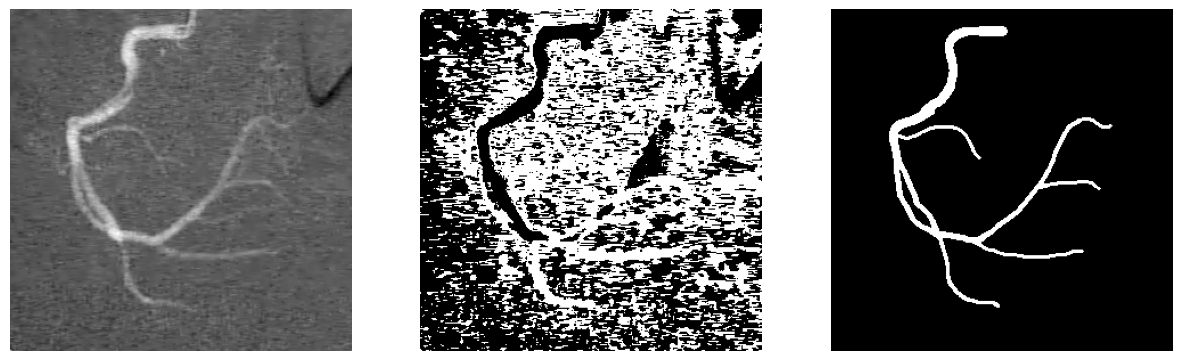

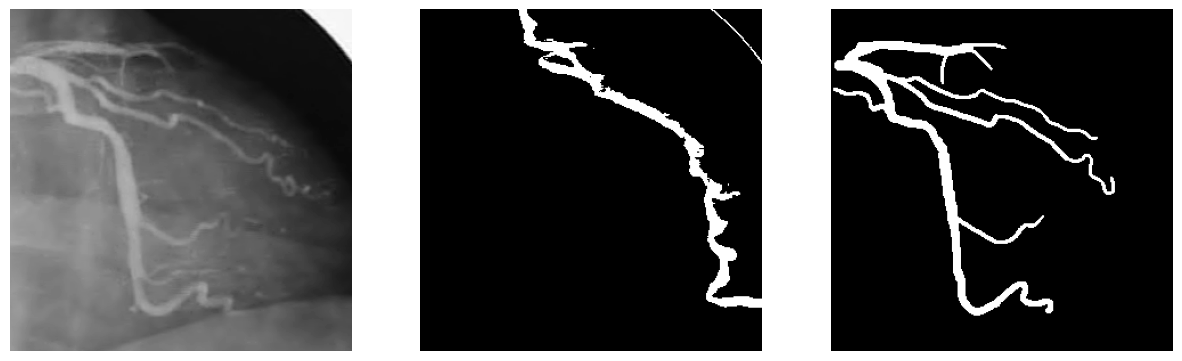

In [9]:
minIntensity = 55
sauvolaMetricsSum = np.zeros(5)

for i in range(1, 21):
    ruta = f"{path}{i}.pgm"
    rutaAnalizada = f"{path}{i}_gt.pgm"

    originalImageGray = readImage(ruta) * 255
    gtImage = readImage(rutaAnalizada) * 255

    mask = originalImageGray > minIntensity
    imageForSauvola = originalImageGray.copy()
    imageForSauvola[~mask] = 255

    sauvolaThresh = sauvolaThreshold(imageForSauvola)
    sauvolaBinary = (imageForSauvola > sauvolaThresh).astype(np.uint8)
    sauvolaBinary = 1 - sauvolaBinary

    gtNormalized = (gtImage == 255).astype(np.uint8)
    sauvolaMetrics = evaluateMetrics(gtNormalized, sauvolaBinary)
    sauvolaMetricsSum += sauvolaMetrics

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(originalImageGray, cmap='gray')
    ax[0].axis('off')

    ax[1].imshow(sauvolaBinary, cmap='gray')
    ax[1].axis('off')

    ax[2].imshow(gtImage, cmap='gray')
    ax[2].axis('off')

    plt.show()

In [10]:
metricsAvg = sauvolaMetricsSum / 20

print('\n--- metrics sauvola ---')
print('accuracy:', metricsAvg[0])
print('f1:', metricsAvg[4])
print('recall/sensitivity:', metricsAvg[2])
print('specificity:', metricsAvg[3])
print('precision:', metricsAvg[1])



--- metrics sauvola ---
accuracy: 0.9534605555555556
f1: 0.0
recall/sensitivity: 0.0
specificity: 0.9534605555555556
precision: 0.0


### Adaptive

In [11]:
def adaptiveThreshold(image, windowSize=11, C=2):
    rows, cols = image.shape
    padSize = windowSize // 2
    padded = np.pad(image, padSize, mode='reflect')
    binaryImage = np.zeros_like(image)

    for i in range(rows):
        for j in range(cols):
            window = padded[i:i+windowSize, j:j+windowSize]
            localMean = np.mean(window)
            threshold = localMean - C
            binaryImage[i, j] = 0 if image[i, j] > threshold else 1

    return binaryImage.astype(np.uint8)

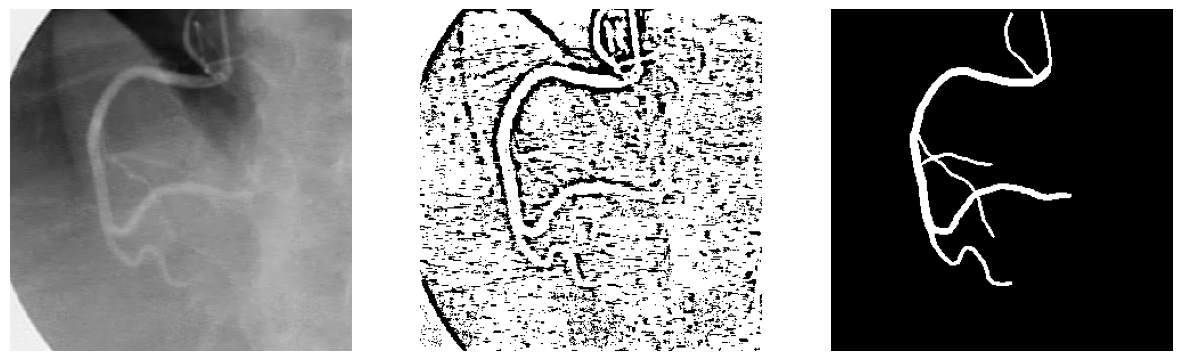

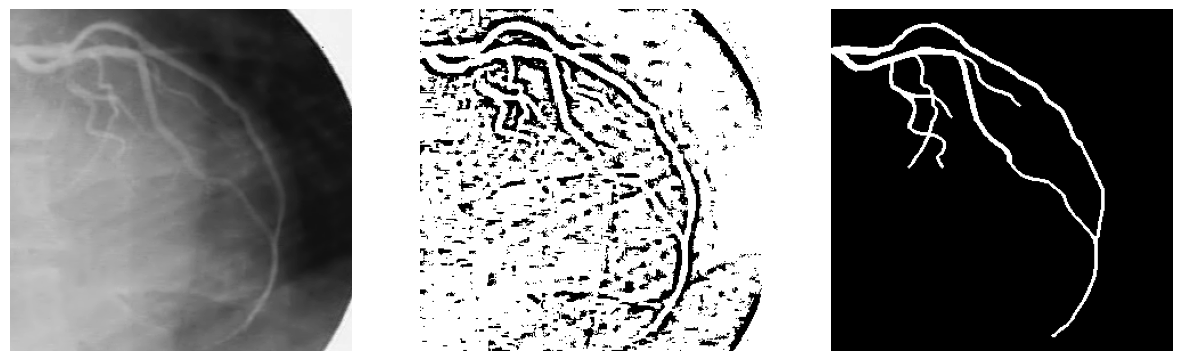

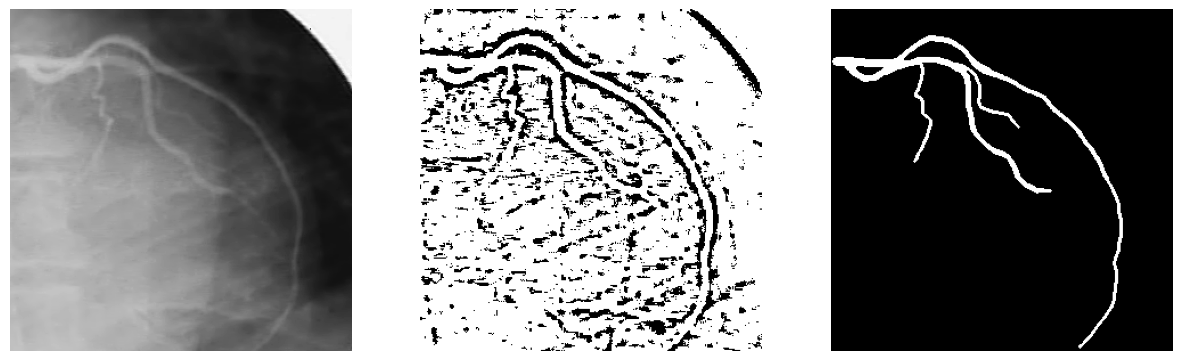

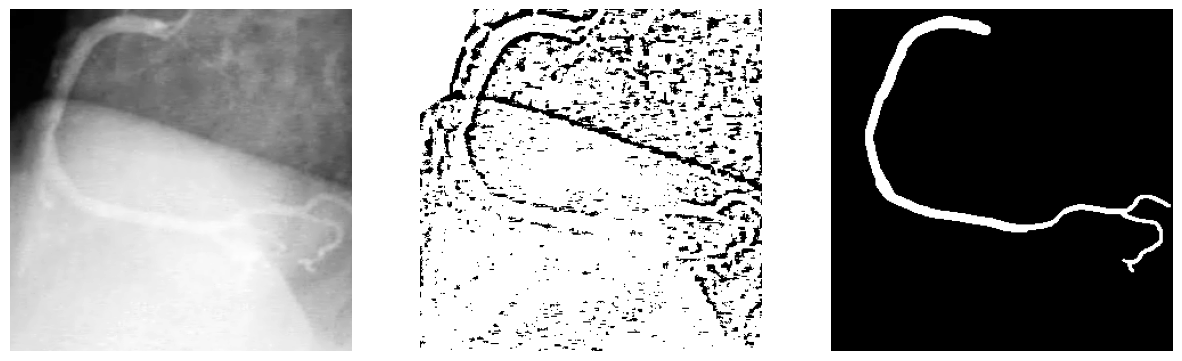

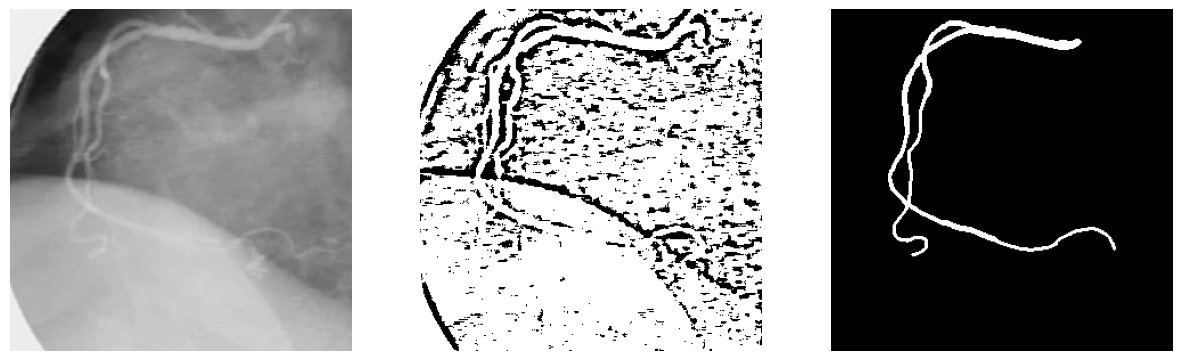

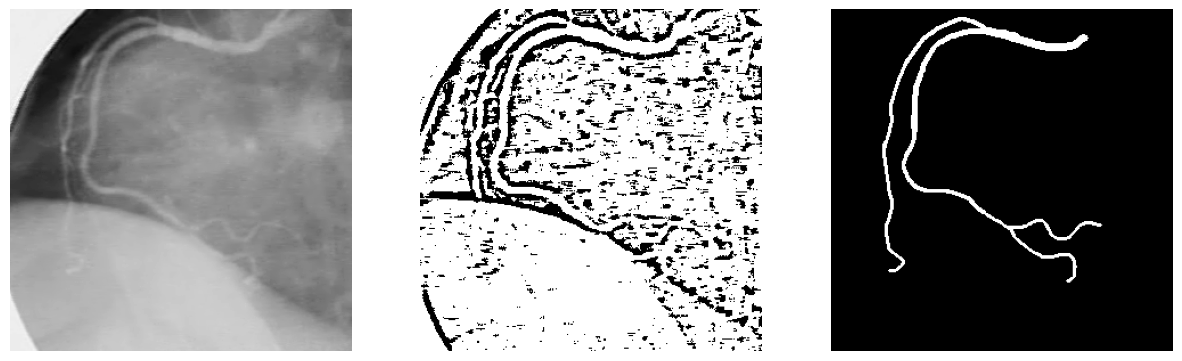

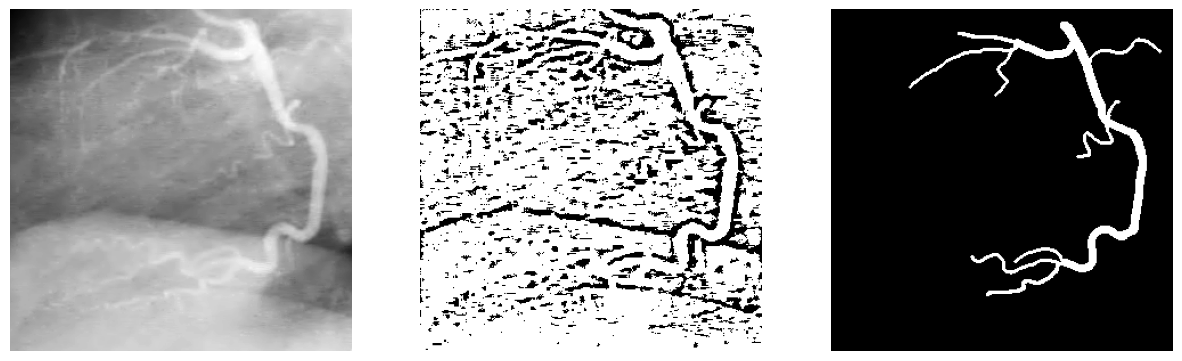

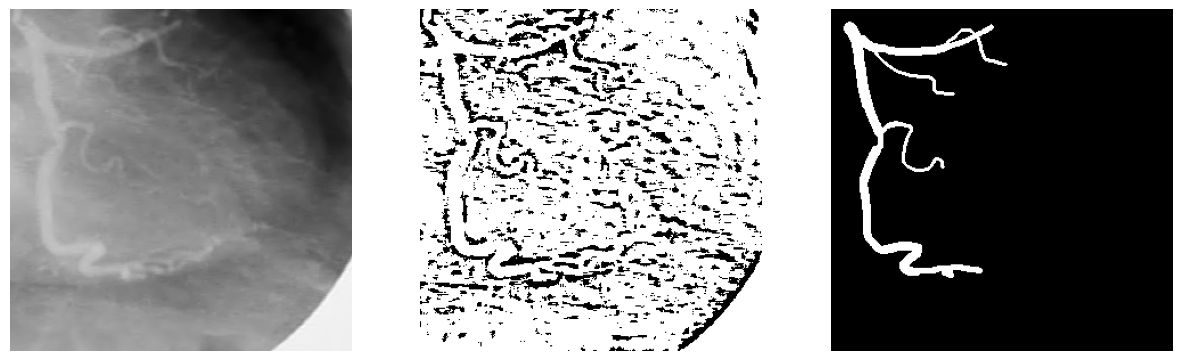

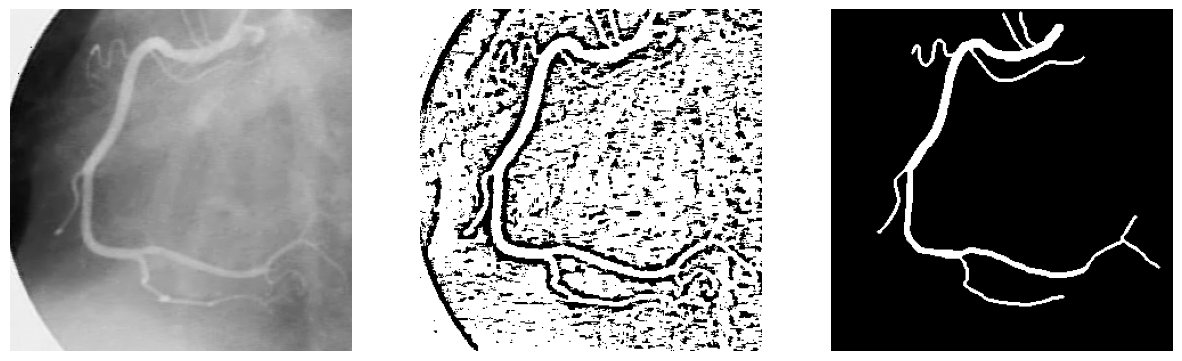

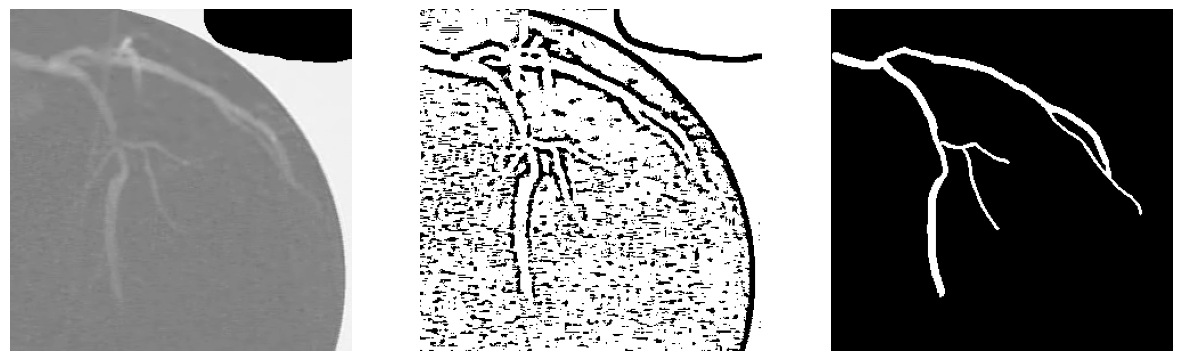

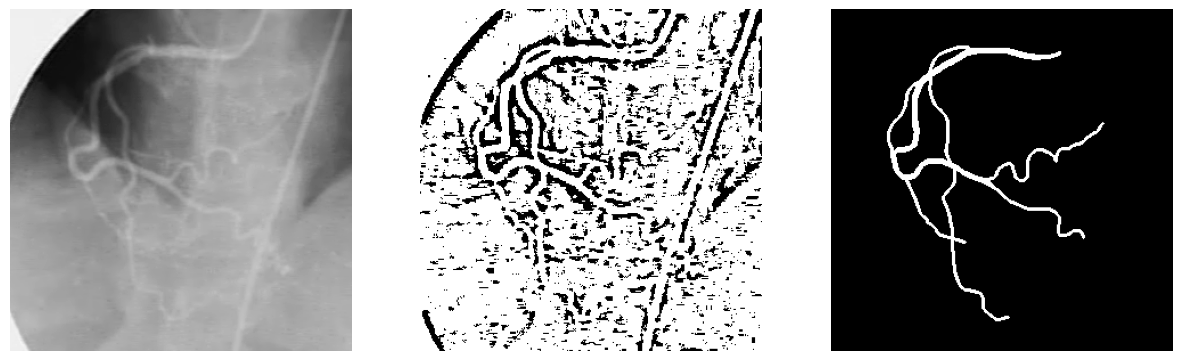

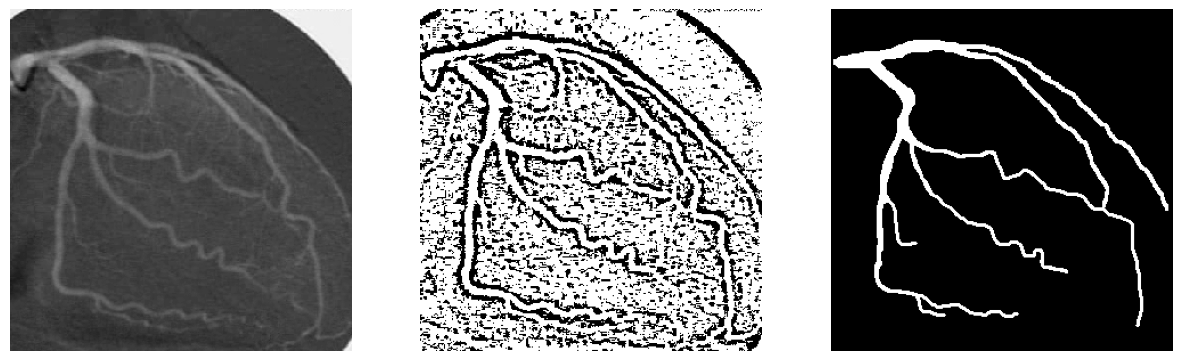

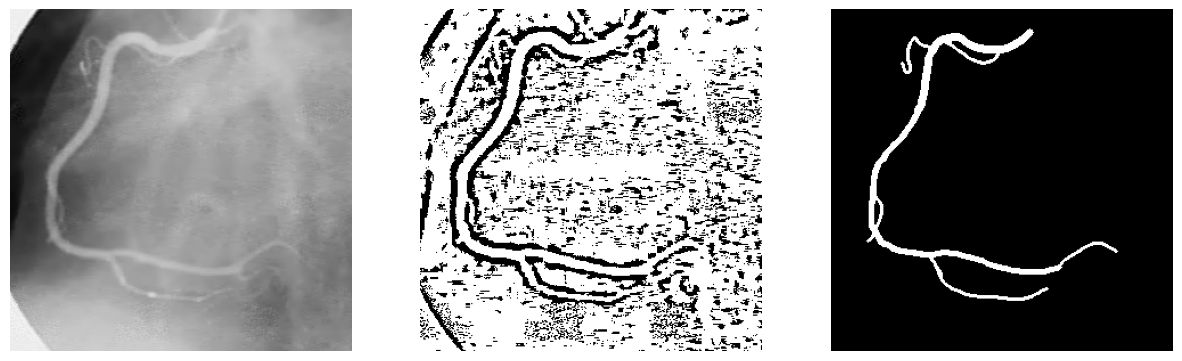

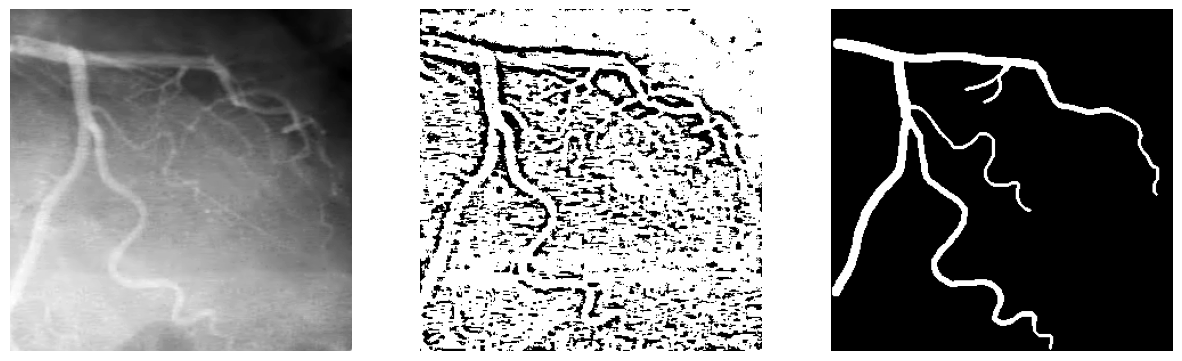

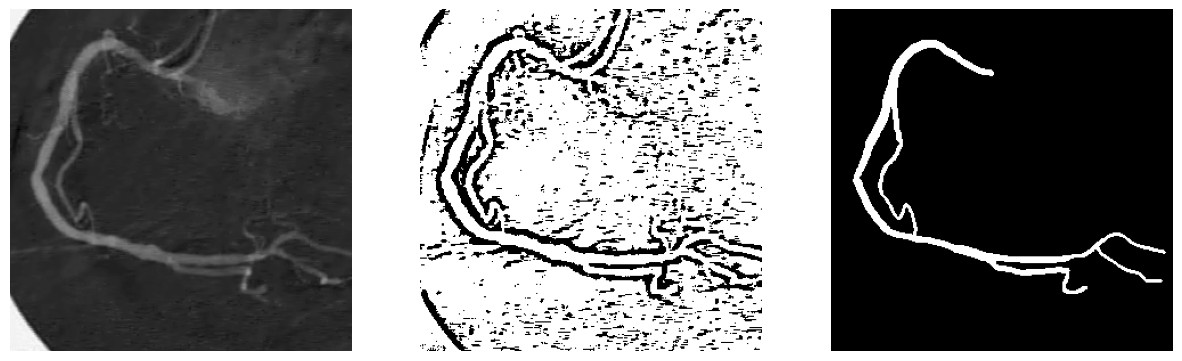

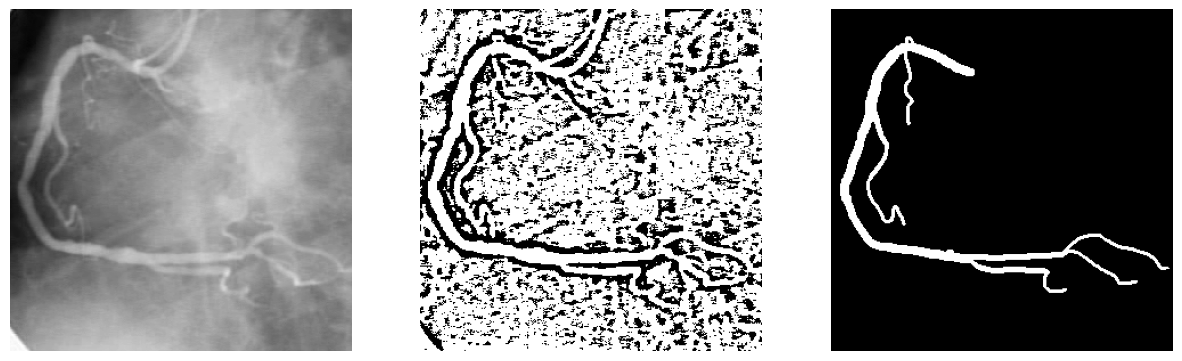

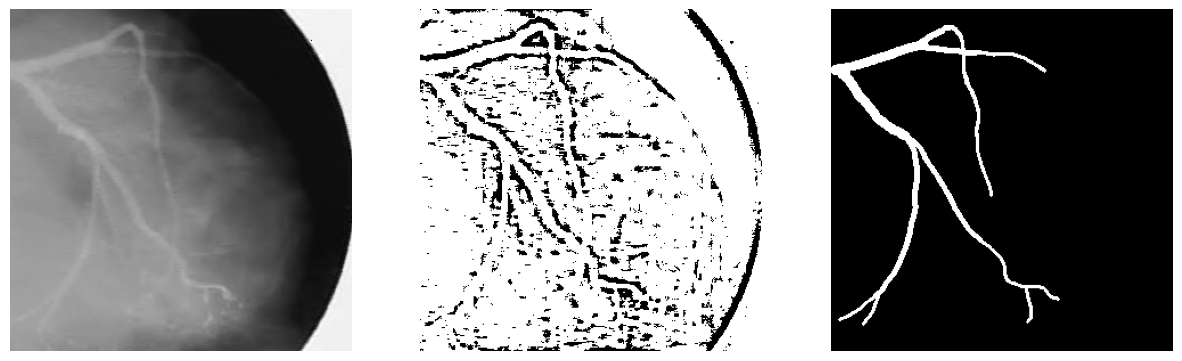

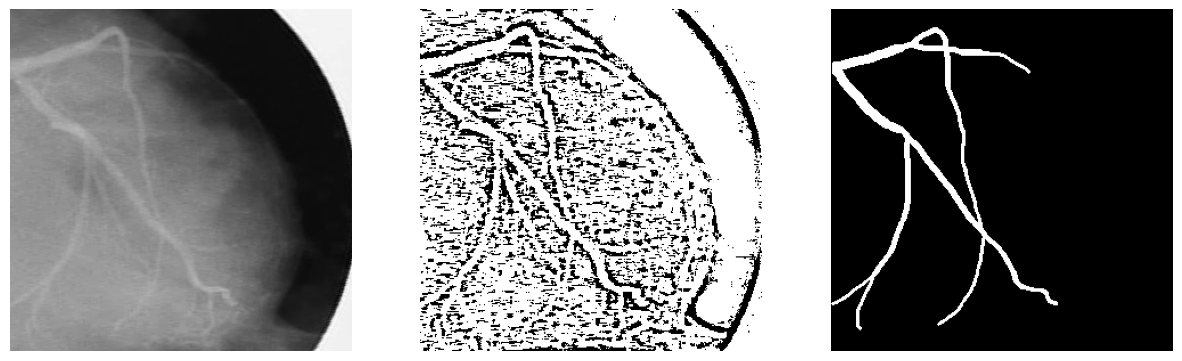

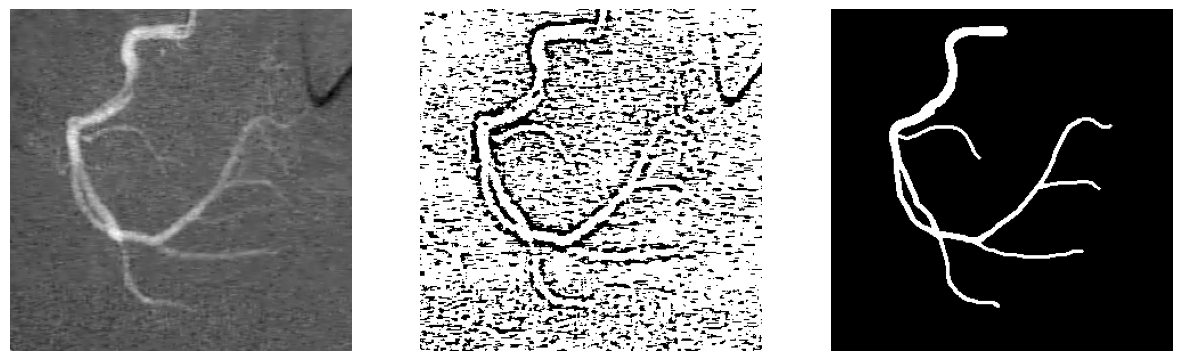

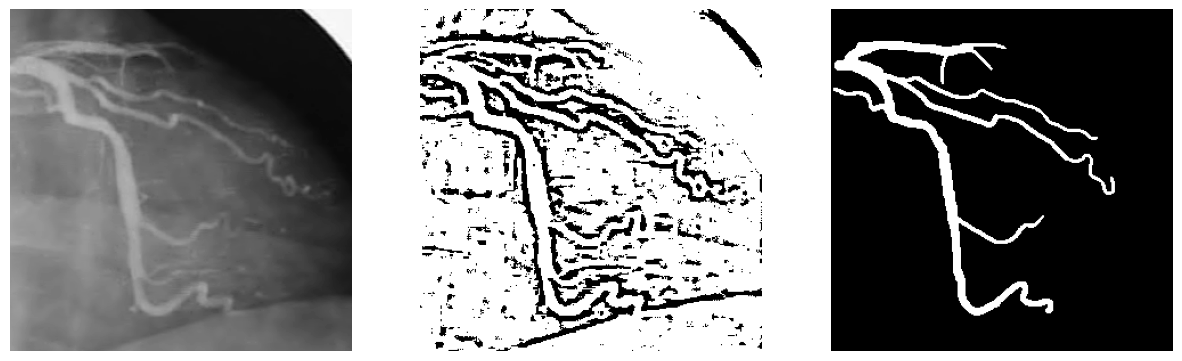

In [12]:
adaptiveMetricsSum = np.zeros(5)

for i in range(1, 21):
    ruta = f"{path}{i}.pgm"
    rutaAnalizada = f"{path}{i}_gt.pgm"

    originalImage = readImage(ruta) * 255
    gtImage = readImage(rutaAnalizada) * 255
    gtNormalized = (gtImage == 255).astype(np.uint8)

    adaptiveBinary = adaptiveThreshold(originalImage)
    adaptiveBinary = 1 - adaptiveBinary

    adaptiveMetrics = evaluateMetrics(gtNormalized, adaptiveBinary)
    adaptiveMetricsSum += adaptiveMetrics

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(originalImage, cmap='gray')
    ax[0].axis('off')

    ax[1].imshow(adaptiveBinary, cmap='gray')
    ax[1].axis('off')

    ax[2].imshow(gtImage, cmap='gray')
    ax[2].axis('off')

    plt.show()

metricsAvg = adaptiveMetricsSum / 20

In [13]:
print('\n--- metrics adaptive ---')
print('accuracy:', metricsAvg[0])
print('f1:', metricsAvg[4])
print('recall/sensitivity:', metricsAvg[2])
print('specificity:', metricsAvg[3])
print('precision:', metricsAvg[1])


--- metrics adaptive ---
accuracy: 0.20788777777777775
f1: 0.0
recall/sensitivity: 0.0
specificity: 0.20788777777777775
precision: 0.0
